In [83]:
import sys
import os
sys.path.append("../") 
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import geopandas as gpd
from exploratory_data_analysis import omnivida_loader as ov
from exploratory_data_analysis import omnivida_util as ovu
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from sklearn.tree import export_graphviz
import pydotplus
import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
adherence, adherence_change = ov.get_adherence_dataset()
basic_info = ov.get_basic_info_dataset()
familiar_records = ov.get_family_records_dataset()
life_quality = ov.get_wellbeing_index_dataset()

In [3]:
select_fields = ['id_patient', 'survey_date', 'category', 'qualitative_result', 'qualitative_result_change', 'days_since_last_control', 'ongoing_adherence_percentage', 'num_reports']
adherence_change_analysis = adherence_change[select_fields]
adherence_change_analysis.head(30)

,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports
0,500547,2016-07-11,A,1.0,NaN,NaN,100.000000,1
1,500547,2019-03-14,A,1.0,0.0,976.0,100.000000,2
2,500547,2019-10-11,A,1.0,0.0,211.0,100.000000,3
3,500547,2019-12-09,A,1.0,0.0,59.0,100.000000,4
4,500547,2020-01-16,A,1.0,0.0,38.0,100.000000,5
5,500547,2020-03-25,A,1.0,0.0,69.0,100.000000,6
6,500547,2020-05-08,A,1.0,0.0,44.0,100.000000,7
7,500588,2019-04-26,A,1.0,NaN,NaN,100.000000,1
8,502989,2014-08-22,M,0.0,NaN,NaN,0.000000,1
9,502989,2014-10-28,M,0.0,0.0,67.0,0.000000,2


In [4]:
bi_adherence = adherence_change_analysis.merge(basic_info, how='left', on='id_patient')
bi_adherence['category'] = bi_adherence['category'].astype('category')
bi_adherence['category'].cat.reorder_categories(['N', 'N+', 'M', 'A-', 'A'], ordered=True, inplace=True)
bi_adherence['age_at_survey_date'] = (np.ceil((bi_adherence['survey_date'] - bi_adherence['birthdate']) / np.timedelta64(1, 'Y'))).astype(int)
bi_adherence.drop(columns=['city', 'department', 'age'], axis=1, inplace=True)

In [5]:
bi_adherence

,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,gender,education,civil_status,social_stratum,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_at_survey_date
0,500547,2016-07-11,A,1.0,NaN,NaN,100.0,1,M,SECUNDARIA,CASADO (A),3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,55
1,500547,2019-03-14,A,1.0,0.0,976.0,100.0,2,M,SECUNDARIA,CASADO (A),3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,57
2,500547,2019-10-11,A,1.0,0.0,211.0,100.0,3,M,SECUNDARIA,CASADO (A),3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,58
3,500547,2019-12-09,A,1.0,0.0,59.0,100.0,4,M,SECUNDARIA,CASADO (A),3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,58
4,500547,2020-01-16,A,1.0,0.0,38.0,100.0,5,M,SECUNDARIA,CASADO (A),3.0,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,1999536,2018-08-08,A,1.0,NaN,NaN,100.0,1,F,UNIVERSITARIO,SOLTERO (A),4.0,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1991-09-10,27
4761,1999536,2020-02-22,A,1.0,0.0,563.0,100.0,2,F,UNIVERSITARIO,SOLTERO (A),4.0,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1991-09-10,29
4762,1999629,2018-04-06,A,1.0,NaN,NaN,100.0,1,F,PRIMARIA,SOLTERO (A),3.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,COTIZANTE,SIN EMPLEO,1998-11-14,20
4763,1999629,2018-05-04,A,1.0,0.0,28.0,100.0,2,F,PRIMARIA,SOLTERO (A),3.0,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,COTIZANTE,SIN EMPLEO,1998-11-14,20


In [6]:
respiratory_related_diagnosis = ['ASMA MIXTA', 'ASMA NO ALERGICA', 'ASMA, NO ESPECIFICADA', 
                                 'CARCINOMA IN SITU DEL BRONQUIO Y DEL PULMON', 'ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, NO ESPECIFICADA']

consolidated_family_record = pd.DataFrame()
for paciente, df in familiar_records.groupby('id_patient'):
    temp_df = df.copy()
    row = {}
    row['id_patient'] = int(paciente)
    row['family_history_reported'] = 1
    row['num_family_records'] = temp_df.shape[0]
    row['family_respiratory_related_diagnosis'] = len(temp_df[temp_df.diagnosis.isin(respiratory_related_diagnosis)])
    row['family_non_respiratory_related_diagnosis'] = len(temp_df[~temp_df.diagnosis.isin(respiratory_related_diagnosis)])
    consolidated_family_record = consolidated_family_record.append(row, ignore_index=True)

# Rearrange columns
consolidated_family_record = consolidated_family_record[
    ['id_patient', 'family_respiratory_related_diagnosis', 'family_non_respiratory_related_diagnosis']
]

consolidated_family_record

,id_patient,family_respiratory_related_diagnosis,family_non_respiratory_related_diagnosis
0,529410.0,0.0,1.0
1,535255.0,0.0,1.0
2,557377.0,0.0,1.0
3,664340.0,2.0,0.0
4,673765.0,1.0,0.0
5,674247.0,1.0,6.0
6,679525.0,0.0,1.0
7,716377.0,1.0,0.0
8,738900.0,0.0,1.0
9,788432.0,0.0,4.0


In [7]:
bi_fr_adherence = bi_adherence.merge(consolidated_family_record, how='left', on='id_patient')
bi_fr_adherence['family_respiratory_related_diagnosis'] = bi_fr_adherence['family_respiratory_related_diagnosis'].fillna(0)
bi_fr_adherence['family_non_respiratory_related_diagnosis'] = bi_fr_adherence['family_non_respiratory_related_diagnosis'].fillna(0)
bi_fr_adherence

,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,gender,education,...,zone,socioeconomic_level,occupation,social_security_regime,social_security_affiliation_type,employment_type,birthdate,age_at_survey_date,family_respiratory_related_diagnosis,family_non_respiratory_related_diagnosis
0,500547,2016-07-11,A,1.0,NaN,NaN,100.0,1,M,SECUNDARIA,...,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,55,0.0,0.0
1,500547,2019-03-14,A,1.0,0.0,976.0,100.0,2,M,SECUNDARIA,...,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,57,0.0,0.0
2,500547,2019-10-11,A,1.0,0.0,211.0,100.0,3,M,SECUNDARIA,...,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,58,0.0,0.0
3,500547,2019-12-09,A,1.0,0.0,59.0,100.0,4,M,SECUNDARIA,...,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,58,0.0,0.0
4,500547,2020-01-16,A,1.0,0.0,38.0,100.0,5,M,SECUNDARIA,...,URBANA,A,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1962-05-19,58,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,1999536,2018-08-08,A,1.0,NaN,NaN,100.0,1,F,UNIVERSITARIO,...,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1991-09-10,27,0.0,0.0
4761,1999536,2020-02-22,A,1.0,0.0,563.0,100.0,2,F,UNIVERSITARIO,...,URBANA,B,EMPLEADO,CONTRIBUTIVO,COTIZANTE,EMPLEADO,1991-09-10,29,0.0,0.0
4762,1999629,2018-04-06,A,1.0,NaN,NaN,100.0,1,F,PRIMARIA,...,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,COTIZANTE,SIN EMPLEO,1998-11-14,20,1.0,1.0
4763,1999629,2018-05-04,A,1.0,0.0,28.0,100.0,2,F,PRIMARIA,...,URBANA,A,ESTUDIANTE,CONTRIBUTIVO,COTIZANTE,SIN EMPLEO,1998-11-14,20,1.0,1.0


In [8]:
bi_fr_adherence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765 entries, 0 to 4764
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   id_patient                                4765 non-null   int64         
 1   survey_date                               4765 non-null   datetime64[ns]
 2   category                                  4765 non-null   category      
 3   qualitative_result                        4765 non-null   float64       
 4   qualitative_result_change                 3925 non-null   float64       
 5   days_since_last_control                   3925 non-null   float64       
 6   ongoing_adherence_percentage              4765 non-null   float64       
 7   num_reports                               4765 non-null   int64         
 8   gender                                    4765 non-null   category      
 9   education                     

Text(0.5,1,'Correlation Matrix')

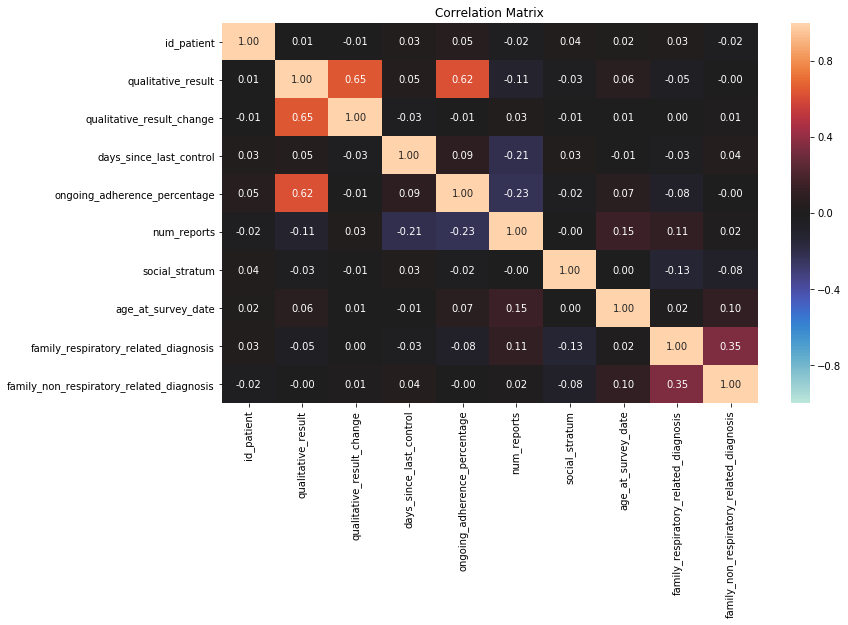

In [9]:
corr_bi_fr_adherence = bi_fr_adherence.corr()
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_bi_fr_adherence, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [10]:
pivoted_life_quality = pd.DataFrame()
for patient, df in life_quality.groupby('id_patient'):
    pvt = df.pivot(index='creation_date', columns='dimension', values='score')
    pvt.columns = pvt.columns.categories
    pvt.reset_index(inplace=True)
    pvt['id_patient'] = patient
    cols = [list(pvt.columns)[-1]] + list(pvt.columns)[:-1]
    pvt = pvt[cols]
    pivoted_life_quality = pivoted_life_quality.append(pvt, ignore_index=True)
#     display(pivoted_life_quality)

pivoted_life_quality.columns = ['id_patient', 'creation_date', 'personal_environment', 'psychological_health', 'interpersonal_relationships', 'physical_health']
pivoted_life_quality['wb_score'] = (pivoted_life_quality['personal_environment'] + pivoted_life_quality['psychological_health'] + pivoted_life_quality['interpersonal_relationships'] + pivoted_life_quality['physical_health']) / 4.
pivoted_life_quality

,id_patient,creation_date,personal_environment,psychological_health,interpersonal_relationships,physical_health,wb_score
0,502989,2017-01-03,63.0,69.0,50.0,63.0,61.25
1,524006,2015-09-10,56.0,69.0,44.0,44.0,53.25
2,524006,2015-11-18,100.0,94.0,75.0,94.0,90.75
3,524006,2016-03-18,100.0,94.0,94.0,100.0,97.00
4,524006,2016-08-08,100.0,94.0,94.0,100.0,97.00
...,...,...,...,...,...,...,...
248,1962088,2016-12-20,63.0,69.0,69.0,31.0,58.00
249,1978721,2015-06-02,63.0,81.0,56.0,63.0,65.75
250,1978721,2015-09-14,69.0,75.0,56.0,63.0,65.75
251,1991750,2017-01-13,81.0,69.0,69.0,63.0,70.50


In [11]:
adherence_change_life_quality = ovu.merge_on_closest_date(df1=adherence_change_analysis, df2=pivoted_life_quality, date_field_df1='survey_date', date_field_df2='creation_date', merge_on='id_patient')
adherence_change_life_quality.rename(columns={'days_since_creation_date': 'days_since_last_well_being_survey'}, inplace=True)

period = 30
aclq_timely = adherence_change_life_quality[adherence_change_life_quality.days_since_last_well_being_survey <= period]
aclq_late = adherence_change_life_quality[adherence_change_life_quality.days_since_last_well_being_survey > period]
aclq_timely

,id_patient,survey_date,category,qualitative_result,qualitative_result_change,days_since_last_control,ongoing_adherence_percentage,num_reports,days_since_last_well_being_survey,creation_date,personal_environment,psychological_health,interpersonal_relationships,physical_health,wb_score
0,502989,2017-01-03,M,0.0,-1.0,354.0,22.222222,9,0.0,2017-01-03,63.0,69.0,50.0,63.0,61.25
6,524006,2015-09-10,A-,1.0,0.0,248.0,100.000000,2,0.0,2015-09-10,56.0,69.0,44.0,44.0,53.25
16,524006,2017-08-25,A-,1.0,0.0,28.0,75.000000,12,1.0,2017-08-24,75.0,56.0,31.0,50.0,53.00
19,535255,2016-12-29,A,1.0,0.0,37.0,90.909091,11,0.0,2016-12-29,69.0,75.0,56.0,44.0,61.00
20,535255,2017-04-18,A,1.0,0.0,110.0,91.666667,12,19.0,2017-03-30,75.0,50.0,69.0,56.0,62.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,1941829,2017-03-24,A,1.0,0.0,1.0,100.000000,3,18.0,2017-03-06,69.0,81.0,69.0,81.0,75.00
970,1962088,2017-01-07,A,1.0,NaN,NaN,100.000000,1,18.0,2016-12-20,63.0,69.0,69.0,31.0,58.00
973,1978721,2015-10-05,M,1.0,0.0,25.0,100.000000,2,21.0,2015-09-14,69.0,75.0,56.0,63.0,65.75
980,1991750,2017-01-13,A,1.0,0.0,38.0,100.000000,2,0.0,2017-01-13,81.0,69.0,69.0,63.0,70.50


In [12]:
# i = 0
aclq_timely_summary = pd.DataFrame()
for (patient, survey_date), df in aclq_timely.groupby(['id_patient', 'survey_date']):
#     if (df.shape[0] > 1):
#         display(df)
#         i+=1
#         if i > 4:
#             break
    aclq_timely_summary = aclq_timely_summary.append({
        'id_patient': patient,
        'survey_date': survey_date,
        'num_wb_reports_last_30_days': df.shape[0],
        'wb_score': df.iloc[-1]['wb_score'],
        'days_since_last_wb_survey': df.iloc[-1]['days_since_last_well_being_survey']
    }, ignore_index=True)

In [13]:
aclq_timely_summary

,days_since_last_wb_survey,id_patient,num_wb_reports_last_30_days,survey_date,wb_score
0,0.0,502989.0,1.0,2017-01-03,61.25
1,0.0,524006.0,1.0,2015-09-10,53.25
2,1.0,524006.0,1.0,2017-08-25,53.00
3,0.0,535255.0,1.0,2016-12-29,61.00
4,19.0,535255.0,1.0,2017-04-18,62.50
...,...,...,...,...,...
134,18.0,1941829.0,1.0,2017-03-24,75.00
135,18.0,1962088.0,1.0,2017-01-07,58.00
136,21.0,1978721.0,1.0,2015-10-05,65.75
137,0.0,1991750.0,1.0,2017-01-13,70.50


In [14]:
bi_fr_wb_adherence = bi_fr_adherence.merge(aclq_timely_summary, how='left', on=['id_patient', 'survey_date'])

In [15]:
bi_fr_wb_adherence['days_since_last_wb_survey'] = bi_fr_wb_adherence['days_since_last_wb_survey'].fillna(0)
bi_fr_wb_adherence['days_since_last_control'] = bi_fr_wb_adherence['days_since_last_control'].fillna(0)
bi_fr_wb_adherence['num_wb_reports_last_30_days'] = bi_fr_wb_adherence['num_wb_reports_last_30_days'].fillna(0)
bi_fr_wb_adherence['wb_score'] = bi_fr_wb_adherence['wb_score'].fillna(0)
bi_fr_wb_adherence.drop(columns=['category', 'qualitative_result_change', 'social_security_regime', 'zone', 'social_security_affiliation_type', 'employment_type'], axis=1, inplace=True)

In [16]:
bi_fr_wb_adherence_modelable = bi_fr_wb_adherence.copy()
bi_fr_wb_adherence_modelable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765 entries, 0 to 4764
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   id_patient                                4765 non-null   int64         
 1   survey_date                               4765 non-null   datetime64[ns]
 2   qualitative_result                        4765 non-null   float64       
 3   days_since_last_control                   4765 non-null   float64       
 4   ongoing_adherence_percentage              4765 non-null   float64       
 5   num_reports                               4765 non-null   int64         
 6   gender                                    4765 non-null   category      
 7   education                                 4765 non-null   category      
 8   civil_status                              4765 non-null   category      
 9   social_stratum                

In [17]:
# bi_fr_wb_adherence_modelable['category'] = bi_fr_wb_adherence_modelable['category'].cat.codes
# bi_fr_wb_adherence_modelable['gender'] = bi_fr_wb_adherence_modelable['gender'].cat.codes
bi_fr_wb_adherence_modelable['education'] = bi_fr_wb_adherence_modelable['education'].cat.codes
# bi_fr_wb_adherence_modelable['civil_status'] = bi_fr_wb_adherence_modelable['civil_status'].cat.codes
bi_fr_wb_adherence_modelable['socioeconomic_level'] = bi_fr_wb_adherence_modelable['socioeconomic_level'].cat.codes
# bi_fr_wb_adherence_modelable['occupation'] = bi_fr_wb_adherence_modelable['occupation'].cat.codes
bi_fr_wb_adherence_modelable = pd.get_dummies(bi_fr_wb_adherence_modelable, columns=['gender', 'civil_status', 'occupation'])

Text(0.5,1,'Correlation Matrix')

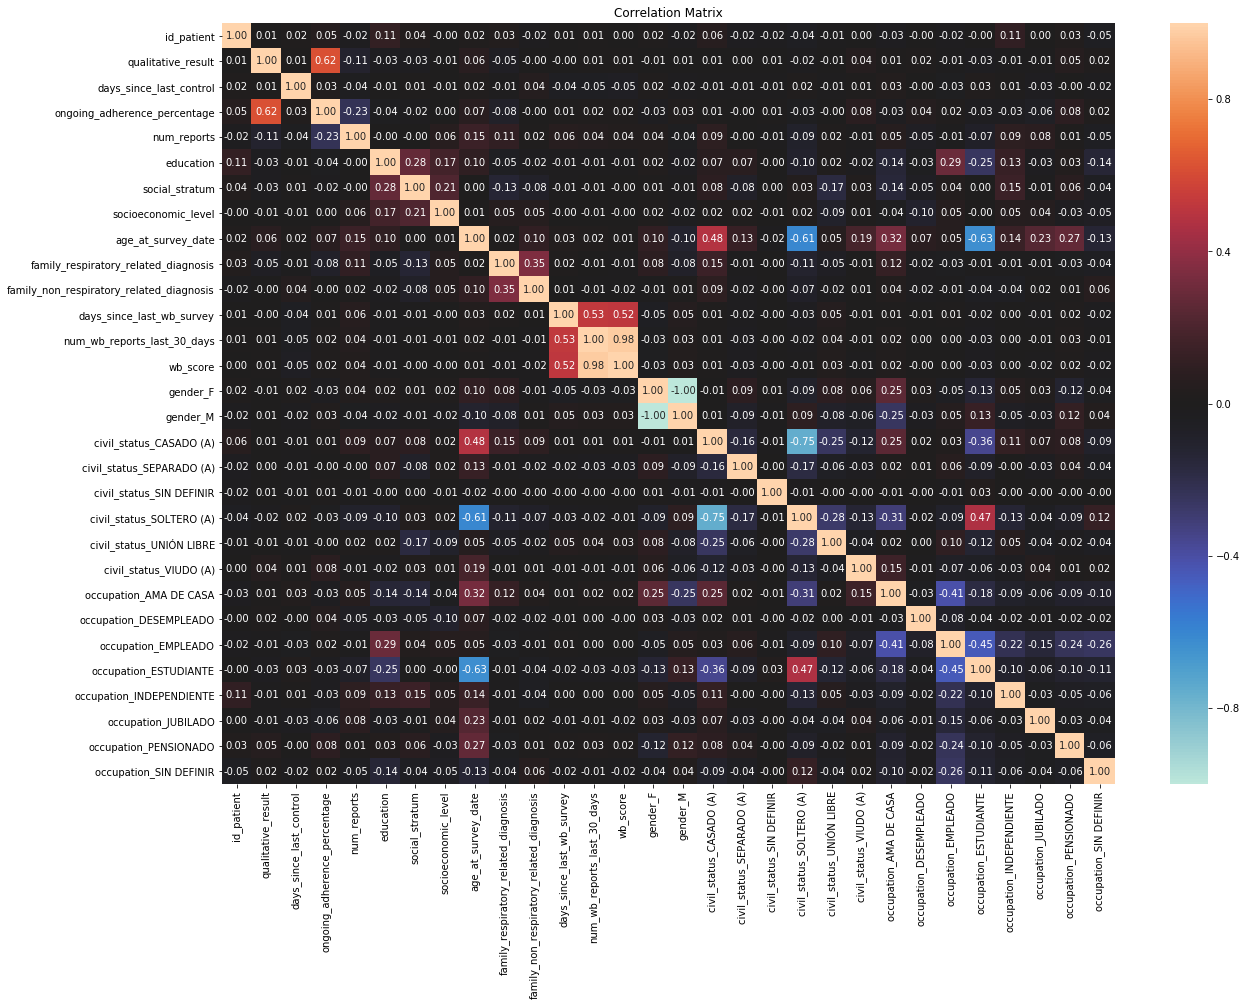

In [18]:
corr_bi_fr_wb_adherence = bi_fr_wb_adherence_modelable.corr()
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(corr_bi_fr_wb_adherence, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

## All covariates

In [19]:
depth = 5
covariates1 = bi_fr_wb_adherence_modelable.columns[~bi_fr_wb_adherence_modelable.columns.isin(['id_patient', 'qualitative_result', 'survey_date', 'birthdate'])]
covariates1

Index(['days_since_last_control', 'ongoing_adherence_percentage',
       'num_reports', 'education', 'social_stratum', 'socioeconomic_level',
       'age_at_survey_date', 'family_respiratory_related_diagnosis',
       'family_non_respiratory_related_diagnosis', 'days_since_last_wb_survey',
       'num_wb_reports_last_30_days', 'wb_score', 'gender_F', 'gender_M',
       'civil_status_CASADO (A)', 'civil_status_SEPARADO (A)',
       'civil_status_SIN DEFINIR', 'civil_status_SOLTERO (A)',
       'civil_status_UNIÓN LIBRE', 'civil_status_VIUDO (A)',
       'occupation_AMA DE CASA', 'occupation_DESEMPLEADO',
       'occupation_EMPLEADO', 'occupation_ESTUDIANTE',
       'occupation_INDEPENDIENTE', 'occupation_JUBILADO',
       'occupation_PENSIONADO', 'occupation_SIN DEFINIR'],
      dtype='object')

In [20]:
bi_fr_wb_adherence_modelable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4765 entries, 0 to 4764
Data columns (total 32 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   id_patient                                4765 non-null   int64         
 1   survey_date                               4765 non-null   datetime64[ns]
 2   qualitative_result                        4765 non-null   float64       
 3   days_since_last_control                   4765 non-null   float64       
 4   ongoing_adherence_percentage              4765 non-null   float64       
 5   num_reports                               4765 non-null   int64         
 6   education                                 4765 non-null   int8          
 7   social_stratum                            4765 non-null   float64       
 8   socioeconomic_level                       4765 non-null   int8          
 9   birthdate                     

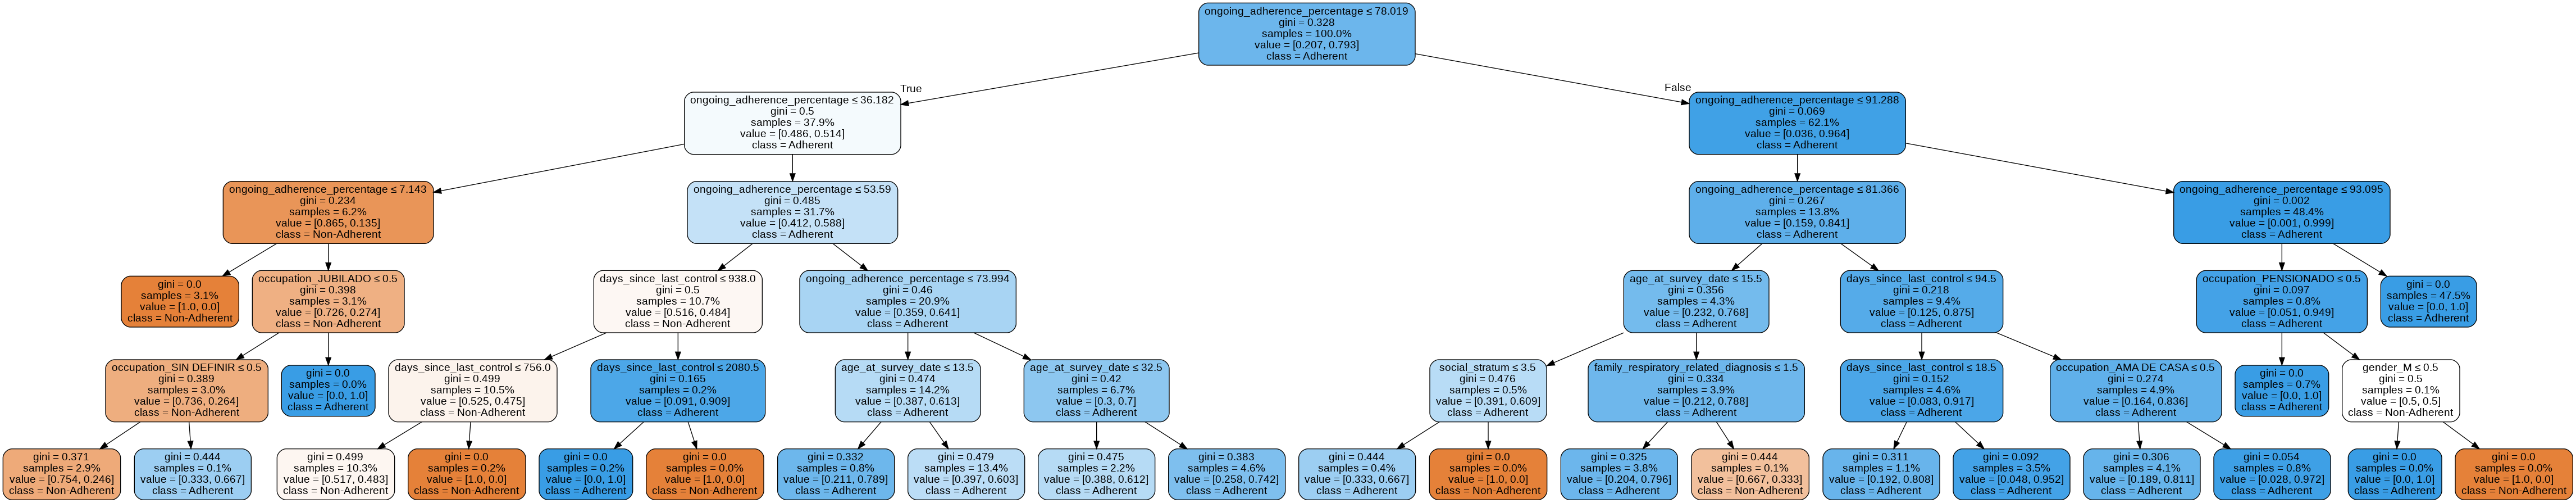

In [21]:
clf = DecisionTreeClassifier(max_depth = depth)

clf = clf.fit(bi_fr_wb_adherence_modelable[covariates1], bi_fr_wb_adherence_modelable['qualitative_result'])

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names = covariates1,
                class_names=['Non-Adherent', 'Adherent'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

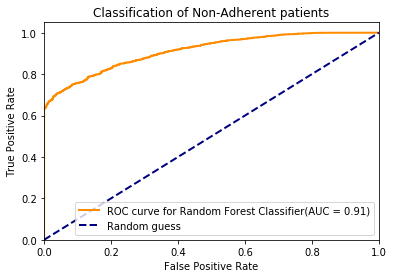

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf.fit(bi_fr_wb_adherence_modelable[covariates1], bi_fr_wb_adherence_modelable['qualitative_result'])
clf_rf_probas = clf_rf.predict_proba(bi_fr_wb_adherence_modelable[covariates1])

roc_p = roc_curve(bi_fr_wb_adherence_modelable['qualitative_result'], clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Non-Adherent patients')
plt.legend(loc='lower right')
plt.show()

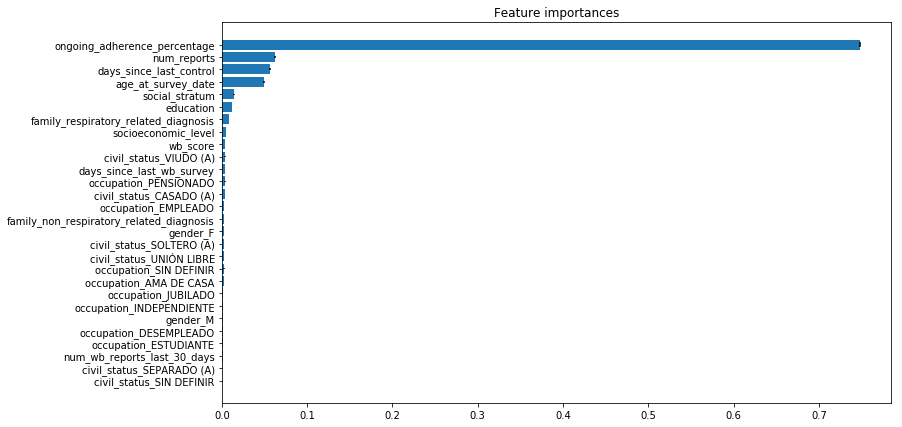

In [23]:
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(bi_fr_wb_adherence_modelable[covariates1].columns[indices], importances[indices], yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

## All covariates except `num_reports`

In [24]:
covariates2 = bi_fr_wb_adherence_modelable.columns[~bi_fr_wb_adherence_modelable.columns.isin(['id_patient', 'qualitative_result', 'survey_date', 'birthdate', 'num_reports'])]
covariates2

Index(['days_since_last_control', 'ongoing_adherence_percentage', 'education',
       'social_stratum', 'socioeconomic_level', 'age_at_survey_date',
       'family_respiratory_related_diagnosis',
       'family_non_respiratory_related_diagnosis', 'days_since_last_wb_survey',
       'num_wb_reports_last_30_days', 'wb_score', 'gender_F', 'gender_M',
       'civil_status_CASADO (A)', 'civil_status_SEPARADO (A)',
       'civil_status_SIN DEFINIR', 'civil_status_SOLTERO (A)',
       'civil_status_UNIÓN LIBRE', 'civil_status_VIUDO (A)',
       'occupation_AMA DE CASA', 'occupation_DESEMPLEADO',
       'occupation_EMPLEADO', 'occupation_ESTUDIANTE',
       'occupation_INDEPENDIENTE', 'occupation_JUBILADO',
       'occupation_PENSIONADO', 'occupation_SIN DEFINIR'],
      dtype='object')

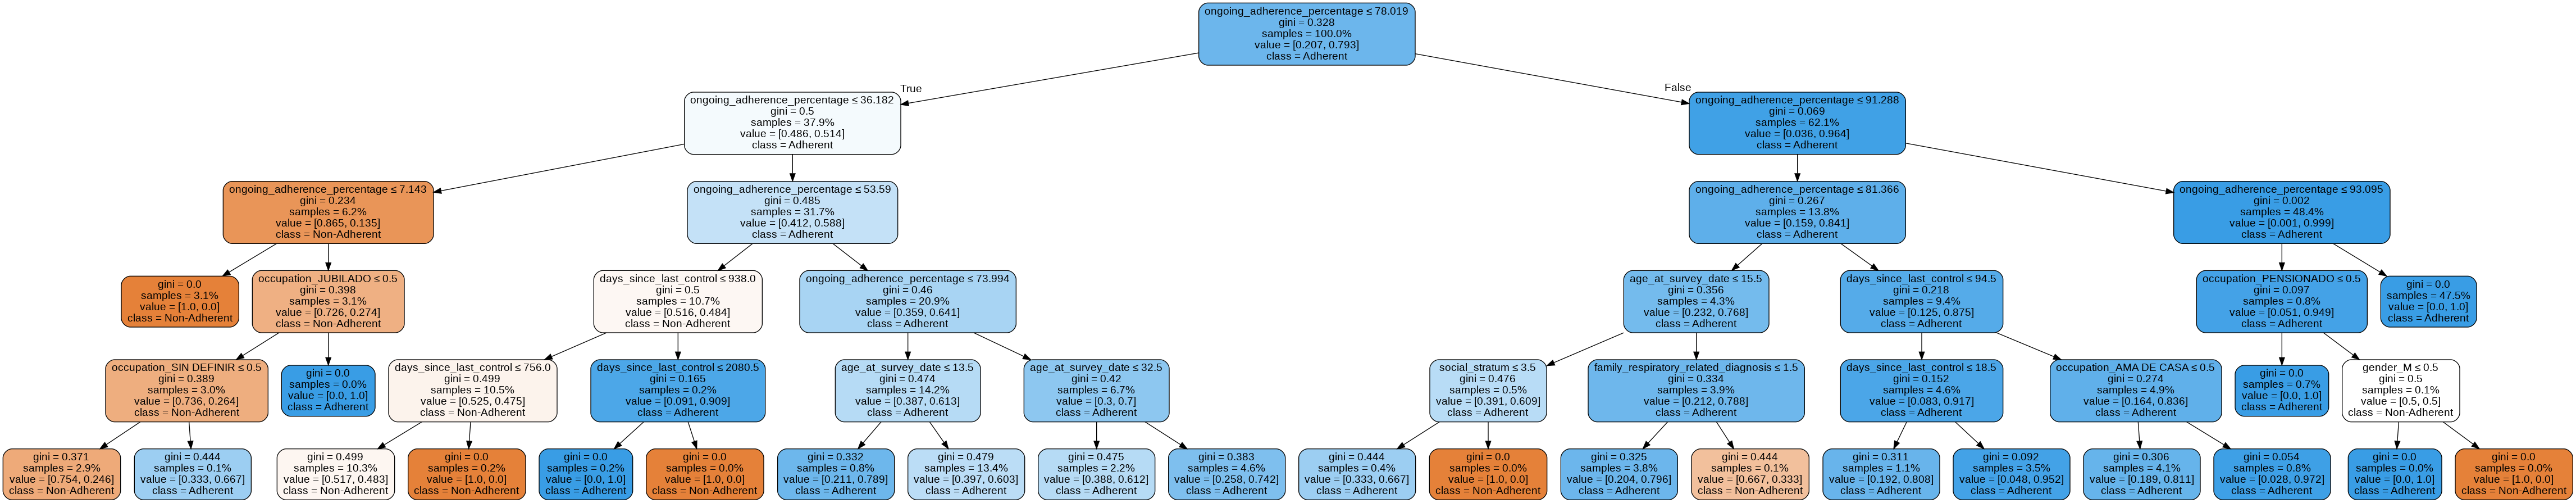

In [25]:
clf2 = DecisionTreeClassifier(max_depth = depth)

clf2 = clf2.fit(bi_fr_wb_adherence_modelable[covariates2], bi_fr_wb_adherence_modelable['qualitative_result'])

dot_data = StringIO()
export_graphviz(clf2, out_file=dot_data, feature_names = covariates2,
                class_names=['Non-Adherent', 'Adherent'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

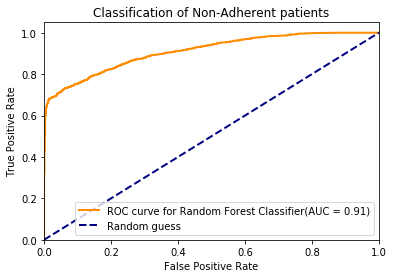

In [26]:
clf2_rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf2_rf.fit(bi_fr_wb_adherence_modelable[covariates2], bi_fr_wb_adherence_modelable['qualitative_result'])
clf2_rf_probas = clf2_rf.predict_proba(bi_fr_wb_adherence_modelable[covariates2])

roc_p = roc_curve(bi_fr_wb_adherence_modelable['qualitative_result'], clf2_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Non-Adherent patients')
plt.legend(loc='lower right')
plt.show()

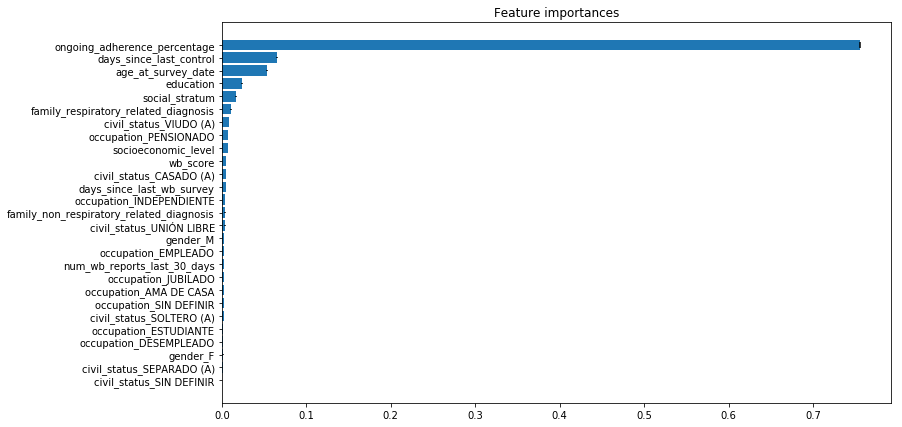

In [27]:
importances = clf2_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf2_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(bi_fr_wb_adherence_modelable[covariates2].columns[indices], importances[indices], yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

## Train and test sets

In [28]:
bi_fr_wb_adherence_train = bi_fr_wb_adherence_modelable[bi_fr_wb_adherence_modelable['survey_date'] < "2020-01-01"]
bi_fr_wb_adherence_test = bi_fr_wb_adherence_modelable[bi_fr_wb_adherence_modelable['survey_date'] > "2019-12-31"]

display(bi_fr_wb_adherence_train)
display(bi_fr_wb_adherence_test)

,id_patient,survey_date,qualitative_result,days_since_last_control,ongoing_adherence_percentage,num_reports,education,social_stratum,socioeconomic_level,birthdate,...,civil_status_UNIÓN LIBRE,civil_status_VIUDO (A),occupation_AMA DE CASA,occupation_DESEMPLEADO,occupation_EMPLEADO,occupation_ESTUDIANTE,occupation_INDEPENDIENTE,occupation_JUBILADO,occupation_PENSIONADO,occupation_SIN DEFINIR
0,500547,2016-07-11,1.0,0.0,100.000000,1,3,3.0,3,1962-05-19,...,0,0,0,0,1,0,0,0,0,0
1,500547,2019-03-14,1.0,976.0,100.000000,2,3,3.0,3,1962-05-19,...,0,0,0,0,1,0,0,0,0,0
2,500547,2019-10-11,1.0,211.0,100.000000,3,3,3.0,3,1962-05-19,...,0,0,0,0,1,0,0,0,0,0
3,500547,2019-12-09,1.0,59.0,100.000000,4,3,3.0,3,1962-05-19,...,0,0,0,0,1,0,0,0,0,0
7,500588,2019-04-26,1.0,0.0,100.000000,1,2,2.0,4,2004-12-19,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4759,1998401,2018-01-29,1.0,504.0,66.666667,12,3,2.0,3,1970-01-11,...,0,0,1,0,0,0,0,0,0,0
4760,1999536,2018-08-08,1.0,0.0,100.000000,1,6,4.0,4,1991-09-10,...,0,0,0,0,1,0,0,0,0,0
4762,1999629,2018-04-06,1.0,0.0,100.000000,1,2,3.0,3,1998-11-14,...,0,0,0,0,0,1,0,0,0,0
4763,1999629,2018-05-04,1.0,28.0,100.000000,2,2,3.0,3,1998-11-14,...,0,0,0,0,0,1,0,0,0,0


,id_patient,survey_date,qualitative_result,days_since_last_control,ongoing_adherence_percentage,num_reports,education,social_stratum,socioeconomic_level,birthdate,...,civil_status_UNIÓN LIBRE,civil_status_VIUDO (A),occupation_AMA DE CASA,occupation_DESEMPLEADO,occupation_EMPLEADO,occupation_ESTUDIANTE,occupation_INDEPENDIENTE,occupation_JUBILADO,occupation_PENSIONADO,occupation_SIN DEFINIR
4,500547,2020-01-16,1.0,38.0,100.000000,5,3,3.0,3,1962-05-19,...,0,0,0,0,1,0,0,0,0,0
5,500547,2020-03-25,1.0,69.0,100.000000,6,3,3.0,3,1962-05-19,...,0,0,0,0,1,0,0,0,0,0
6,500547,2020-05-08,1.0,44.0,100.000000,7,3,3.0,3,1962-05-19,...,0,0,0,0,1,0,0,0,0,0
75,526049,2020-03-06,1.0,1176.0,100.000000,5,3,3.0,4,1968-07-10,...,0,0,0,0,1,0,0,0,0,0
76,526049,2020-03-19,1.0,13.0,100.000000,6,3,3.0,4,1968-07-10,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4711,1990453,2020-05-06,1.0,168.0,72.727273,11,6,2.0,3,1983-04-02,...,0,0,0,0,1,0,0,0,0,0
4726,1995390,2020-04-21,1.0,1091.0,85.714286,7,3,3.0,3,1964-10-22,...,0,0,0,0,1,0,0,0,0,0
4744,1997065,2020-02-19,1.0,498.0,85.714286,14,1,3.0,4,2011-03-20,...,0,0,0,0,0,1,0,0,0,0
4747,1997825,2020-01-16,1.0,168.0,66.666667,3,6,3.0,4,1991-12-27,...,0,0,0,0,1,0,0,0,0,0


#### Decision Tree

Accuracy in training set: 0.8451539338654503
Accuracy in the other samples: 0.9105263157894737


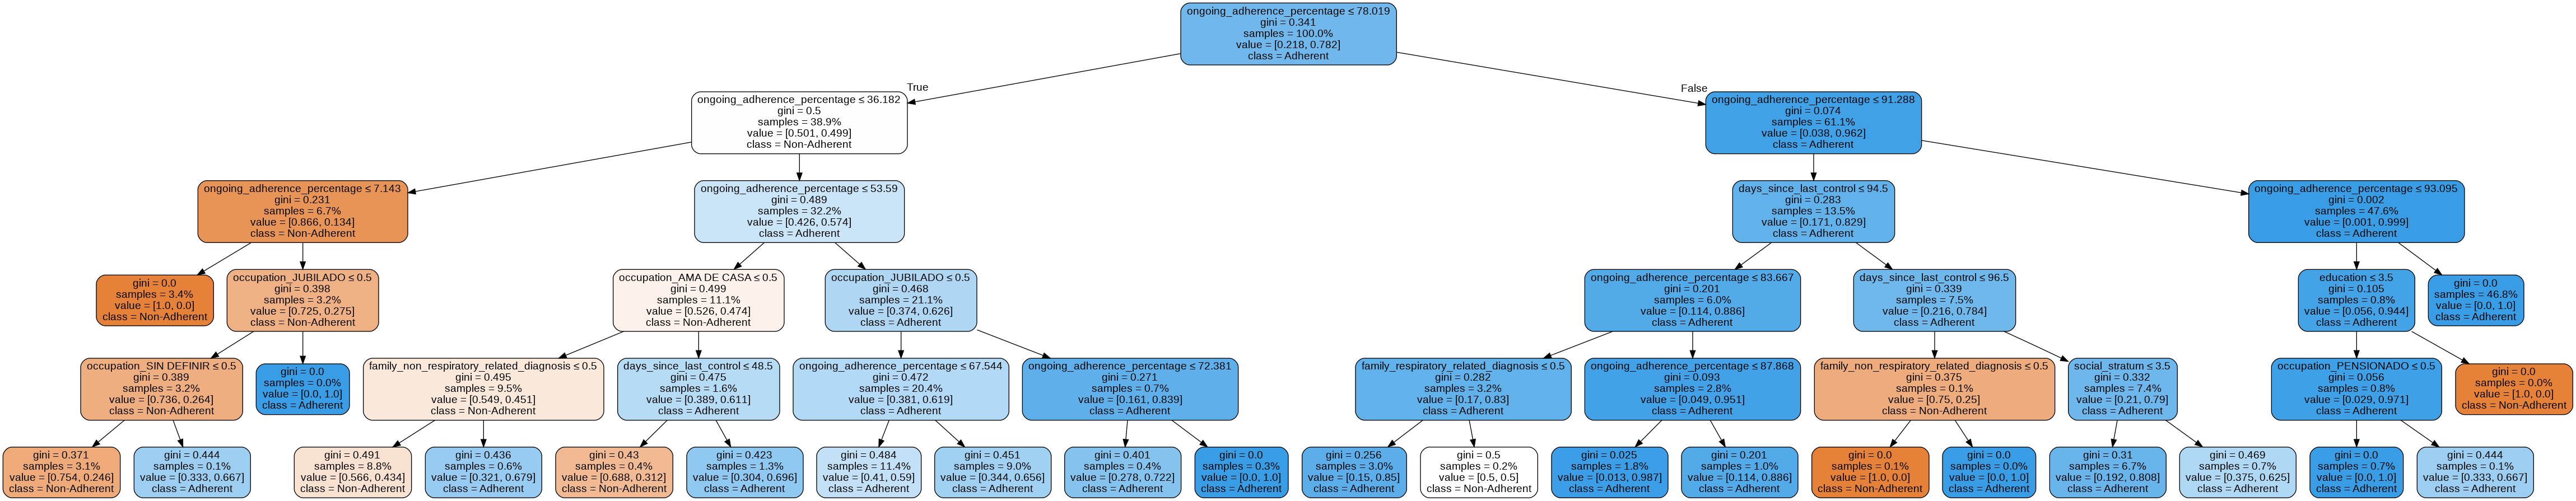

In [29]:
clf_new = DecisionTreeClassifier(max_depth = depth)
clf_new = clf_new.fit(bi_fr_wb_adherence_train[covariates2], bi_fr_wb_adherence_train['qualitative_result'])

y_pred_train = clf_new.predict(bi_fr_wb_adherence_train[covariates2])
y_pred_test = clf_new.predict(bi_fr_wb_adherence_test[covariates2])

print(f"Accuracy in training set: {accuracy_score(bi_fr_wb_adherence_train['qualitative_result'], y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(bi_fr_wb_adherence_test['qualitative_result'], y_pred_test)}")
      
dot_data = StringIO()
export_graphviz(clf_new, out_file=dot_data, feature_names = covariates2,
                class_names=['Non-Adherent', 'Adherent'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Random Forest

In [44]:
clf_rf_new = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf_new.fit(bi_fr_wb_adherence_train[covariates2], bi_fr_wb_adherence_train['qualitative_result'])

y_pred_train = clf_rf_new.predict(bi_fr_wb_adherence_train[covariates2])
y_pred_test = clf_rf_new.predict(bi_fr_wb_adherence_test[covariates2])

print(f"Accuracy in training set: {accuracy_score(bi_fr_wb_adherence_train['qualitative_result'], y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(bi_fr_wb_adherence_test['qualitative_result'], y_pred_test)}")

Accuracy in training set: 0.8132269099201824
Accuracy in the other samples: 0.9342105263157895


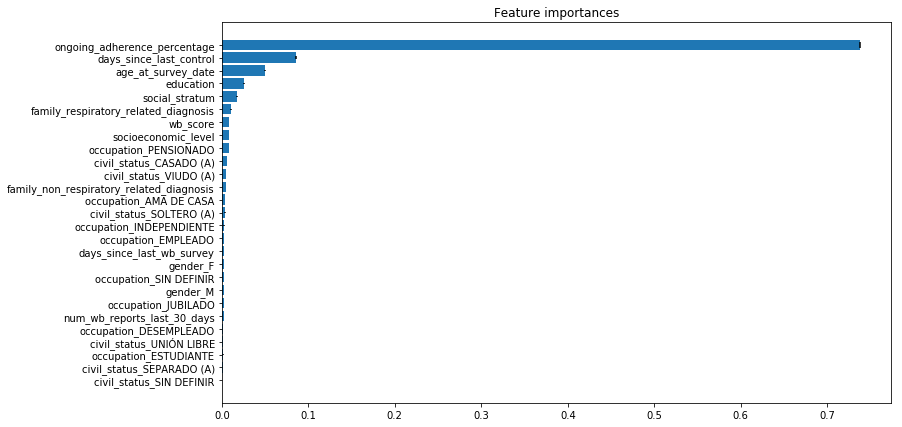

In [45]:
importances = clf_rf_new.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_new.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(bi_fr_wb_adherence_modelable[covariates2].columns[indices], importances[indices], yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

#### XGBoost

In [95]:
#fit model no training data
xgb_model = XGBClassifier(max_depth=depth, random_state=0, booster='gbtree')
xgb_model.fit(bi_fr_wb_adherence_train[covariates2], bi_fr_wb_adherence_train['qualitative_result'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [96]:
y_pred = xgb_model.predict(bi_fr_wb_adherence_test[covariates2])
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(bi_fr_wb_adherence_test['qualitative_result'], predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.95%


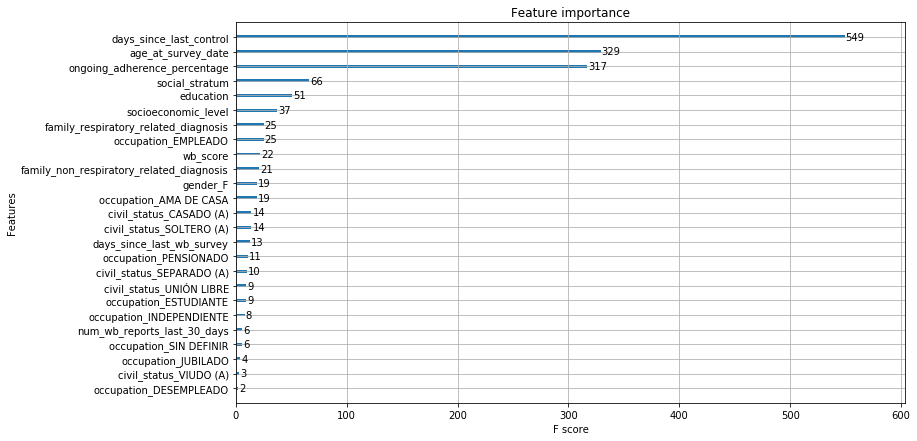

In [97]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(xgb_model, ax=ax)

In [98]:
params_grid = {  
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
    'max_depth': [5,6,7,8,9,10,11,12],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
    'reg_alpha': [20, 21, 22, 23, 24, 25]
}

search_sk = RandomizedSearchCV(xgb_model, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(bi_fr_wb_adherence_train[covariates2], bi_fr_wb_adherence_train['qualitative_result'])

# best parameters
print(search_sk.best_params_)
print(search_sk.best_score_)

{'reg_alpha': 23, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 1.0}
0.8351197263397948


### With the new parameters:

In [99]:
xgb_model_new = XGBClassifier(random_state=0, booster='gbtree', **search_sk.best_params_)
xgb_model_new.fit(bi_fr_wb_adherence_train[covariates2], bi_fr_wb_adherence_train['qualitative_result'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=23,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [100]:
y_pred_new = xgb_model_new.predict(bi_fr_wb_adherence_test[covariates2])
predictions_new = [round(value) for value in y_pred_new]

accuracy = accuracy_score(bi_fr_wb_adherence_test['qualitative_result'], predictions_new)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.32%


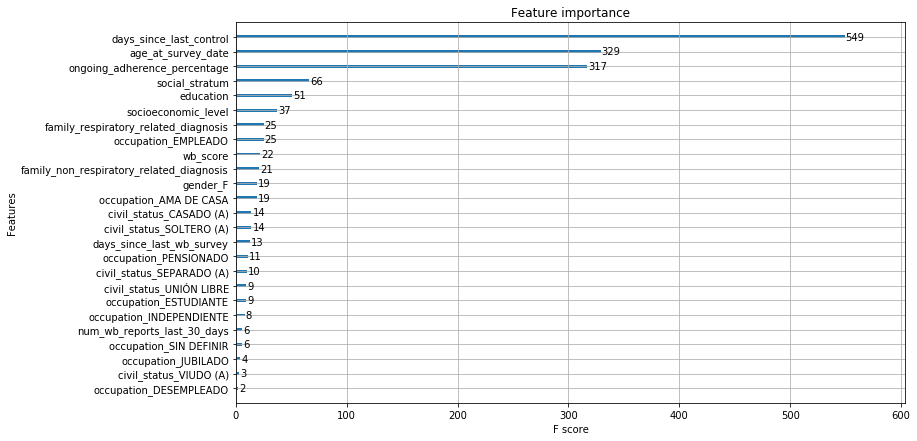

In [101]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(xgb_model, ax=ax)

## Evaluate these three models with cross validation 

In [102]:
def cv_roc_tree(X, y, n_split, algo='Tree', depth=10, params={}):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        if algo == 'Tree':
            clf = DecisionTreeClassifier()
        elif algo == 'forest':
            clf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
        else:
            clf = XGBClassifier(random_state=0, booster='gbtree', verbosity=0, **params)
            
                
        clf = clf.fit(X.iloc[train], y.iloc[train])
        probas_ = clf.predict_proba(X.iloc[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

Text(0.5,1,'Tree-based Classification of Non-adherent patients: 5-fold Cross-validation')

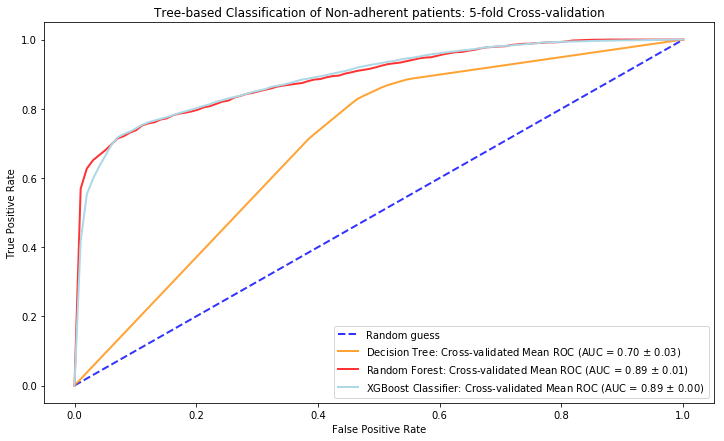

In [103]:
k_folds = 5
tprs_t, aucs_t, mean_fpr_t = cv_roc_tree(bi_fr_wb_adherence_modelable[covariates1], bi_fr_wb_adherence_modelable['qualitative_result'], k_folds, depth=depth)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree(bi_fr_wb_adherence_modelable[covariates1], bi_fr_wb_adherence_modelable['qualitative_result'], k_folds, algo='forest', depth=depth)
tprs_x, aucs_x, mean_fpr_x = cv_roc_tree(bi_fr_wb_adherence_modelable[covariates1], bi_fr_wb_adherence_modelable['qualitative_result'], k_folds, algo='xgboost', params=search_sk.best_params_)

plt.figure(figsize=(12,7))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_t = np.mean(tprs_t, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_x = np.mean(tprs_x, axis=0)
mean_tpr_t[-1] = 1.0
mean_tpr_f[-1] = 1.0
mean_tpr_x[-1] = 1.0

mean_auc_t = auc(mean_fpr_t, mean_tpr_t)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
mean_auc_x = auc(mean_fpr_x, mean_tpr_x)
std_auc_t = np.std(aucs_t)
std_auc_f = np.std(aucs_f)
std_auc_x = np.std(aucs_x)

plt.plot(mean_fpr_t, mean_tpr_t, color='darkorange', lw=2, alpha=.8,
         label=f"Decision Tree: Cross-validated Mean ROC (AUC = {mean_auc_t:0.2f} $\pm$ {std_auc_t:0.2f})")
plt.plot(mean_fpr_f, mean_tpr_f, color='red', lw=2, alpha=.8,
         label=f"Random Forest: Cross-validated Mean ROC (AUC = {mean_auc_f:0.2f} $\pm$ {std_auc_f:0.2f})")
plt.plot(mean_fpr_x, mean_tpr_x, color='lightblue', lw=2, alpha=1.,
         label=f"XGBoost Classifier: Cross-validated Mean ROC (AUC = {mean_auc_x:0.2f} $\pm$ {std_auc_x:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title(f'Tree-based Classification of Non-adherent patients: {k_folds}-fold Cross-validation')